In [1]:
!nvidia-smi

Wed Apr  7 18:45:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical


In [95]:
def create_dataset(dataset):
  
  train = tfds.as_numpy(tfds.load(dataset, split="train", batch_size = -1))
  test  = tfds.as_numpy(tfds.load(dataset, split="test",  batch_size = -1))

  X_Train = train["image"] / 255
  X_Test =  test["image"] / 255
  Y_Train = to_categorical(train["label"])
  Y_Test =  to_categorical(test["label"])
  
  dataset = {"train" : (X_Train, Y_Train), "test" : (X_Test, Y_Test)}
  return dataset

    
class Orthogonalizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, x):
    
        x = tf.reshape(x, (-1, x.shape[-1]))
        proj = tf.transpose(x) @ x
        lower_triangular = tf.linalg.LinearOperatorLowerTriangular(proj).to_dense()
        diag = proj * tf.eye(proj.shape[-1])
        loss = self.factor * tf.norm(lower_triangular - diag) #/ ( (x.shape[-1] * (x.shape[-1] - 1 )) / 2 )

        return loss

    def get_config(self):
        return {"factor": self.factor}
    
    def apply_reg(x):
        for layer in x.layers[:-1]:
            if hasattr(layer, 'kernel_regularizer') and isinstance(layer, tf.keras.layers.Dense):
                layer._handle_weight_regularization(layer.name, layer.kernel, Orthogonalizer(1.0))

class Regularizer_Sum(tf.keras.metrics.Metric):

    def __init__(self, name='reg', **kwargs):
        super(Regularizer_Sum, self).__init__(name=name, **kwargs)
        self.reg = self.add_weight(name='reg', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.reg.assign(sum(model.losses))


    def result(self):
        return self.reg


def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    return x

def identity_block(tensor, filters):
    
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=3, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Add()([tensor,x])    #skip connection
    x = tf.keras.layers.ReLU()(x)
    
    return x


def projection_block(tensor, filters, strides):
    
    #left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=3, strides=strides)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = tf.keras.layers.BatchNormalization()(x)
    
    #right stream
    shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=strides)(tensor)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    
    x = tf.keras.layers.Add()([shortcut,x])    #skip connection
    x = tf.keras.layers.ReLU()(x)
    
    return x

def resnet_block(x, filters, reps, strides):
    
    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
        
    return x


def ResNet10V2(input_shape = (224,224,3)):
    
    inp = tf.keras.layers.Input(shape=input_shape)

    x = conv_batchnorm_relu(inp, filters=64, kernel_size=7, strides=2)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides =2)(x)
    x = resnet_block(x, filters=64//2, reps =2//2, strides=1)
    x = resnet_block(x, filters=128//2, reps =2//2, strides=2)
    x = resnet_block(x, filters=256//2, reps =2//2, strides=2)
    x = resnet_block(x, filters=512//2, reps =2//2, strides=2)
    x = tf.keras.layers.GlobalAvgPool2D()(x)

    output = tf.keras.layers.Dense(1000, activation ='softmax')(x)

    model = tf.keras.models.Model(inputs=inp, outputs=output)
    return model


In [4]:
dataset = "cifar10"#"imagenet_resized" #cifar10, ....
dataset = create_dataset(dataset)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBNLNC2/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBNLNC2/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [98]:
def create_model():

  model = ResNet10V2(dataset["train"][0][0].shape)
  dense = tf.keras.layers.Dense(16, activation = "relu") (model.layers[-2].output)
  y_hat = tf.keras.layers.Dense(10, activation = "softmax") (dense)

  model = tf.keras.models.Model(inputs = model.input, outputs = y_hat)

  return model


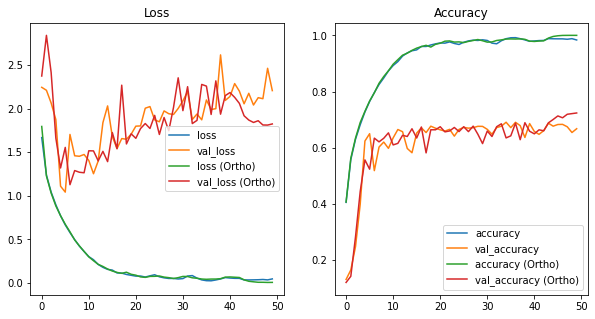

In [ ]:
def train(model, ortho = False):
  if ortho:
    Orthogonalizer.apply_reg(model)
  history = model.fit(
                    dataset["train"][0], dataset["train"][1],  
                    epochs = 50, 
                    batch_size = 512, 
                    validation_data = dataset["test"], verbose = 0 )
  return history

def plot(ax, history, flag):

  if flag:
    suffix = " (Ortho)"
  else:
    suffix = ""

  ax[0].plot(history.epoch, history.history['loss'], label = f'loss{suffix}')
  ax[0].plot(history.epoch, history.history['val_loss'], label = f'val_loss{suffix}')
  ax[1].plot(history.epoch, history.history['accuracy'], label = f'accuracy{suffix}')
  ax[1].plot(history.epoch, history.history['val_accuracy'], label = f'val_accuracy{suffix}')
  ax[0].set_title('Loss')
  ax[1].set_title('Accuracy')
  ax[0].legend()
  ax[1].legend()

def exp():

  fig, ax = plt.subplots(1,2, figsize = (10,5))
  for flag in [False,True]:
    model = create_model()
    model.compile(optimizer=tf.optimizers.Adam(),
                    loss='categorical_crossentropy',  metrics=['accuracy'])
    result = train(model, flag)
    plot(ax, result, flag)
    fig.show()


exp()

#Attend to Accuracy rather than Loss. Loss = Loss + Reg